In [8]:
%config Completer.use_jedi = False

In [9]:
from time import time
import torch
from torch import nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

# Forward KL vs Reverse KL vs JSD

In [10]:
def get_gaussian_log_prob_fn(mu, sigma):
    d = torch.distributions.normal.Normal(mu, sigma)
    fn = lambda x: d.log_prob(x)
    return fn

In [11]:
X = torch.from_numpy(np.linspace(-6,6,500)).double()

In [12]:
single_gaussian = get_gaussian_log_prob_fn(mu=0, sigma=1)

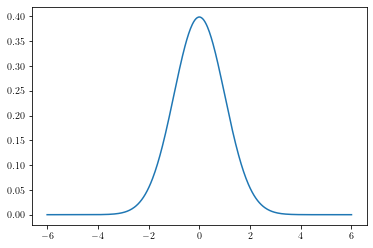

In [13]:
plt.plot(X.numpy(), single_gaussian(X).exp().numpy())

In [14]:
def get_gaussian_mixture_log_prob_fn():
    # define a mixture of gaussians
    k = 0.8
    a = get_gaussian_log_prob_fn(-2, 0.5)
    b = get_gaussian_log_prob_fn(2, 0.5)
    
    # your code here
    fn = lambda x: torch.log(k * a(x).exp() + (1 - k) * b(x).exp())
    return fn

In [20]:
def plot_distributions(X, real_log_prob, model_log_prob=None, title=None, figsize=None, savepath=None):
    with torch.no_grad():
        res1 = real_log_prob(X).exp()
        if model_log_prob is not None:
            res2 = model_log_prob(X).exp()

    if figsize is None:
        figsize = (5, 5)
    plt.figure(figsize=figsize)    
    plt.plot(X.numpy(), res1.numpy(), color='b', linewidth=3, label=r'$\pi(\mathbf{x})$')
    plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res1.numpy(),  color='b', alpha=0.2)
    if model_log_prob is not None:
        plt.plot(X.numpy(), res2.numpy(), 'g', linewidth=3, label=r'$p(\mathbf{x} | \mu, \sigma)$')
        plt.fill_between(X.numpy(), np.zeros_like(X.numpy()), res2.numpy(),  color='g', alpha=0.2)
    if title is not None:
        plt.title(title, fontsize=20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    if savepath is not None:
        plt.savefig(savepath)
    plt.show()

In [21]:
mixture_gaussian = get_gaussian_mixture_log_prob_fn()

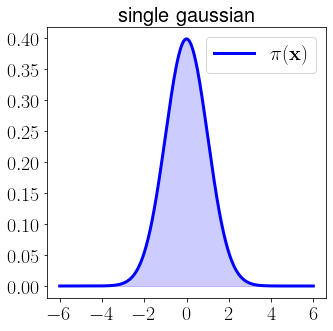

In [22]:
plot_distributions(X, single_gaussian, title='single gaussian')

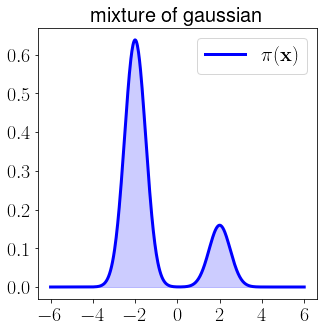

In [23]:
plot_distributions(X, mixture_gaussian, title='mixture of gaussian')

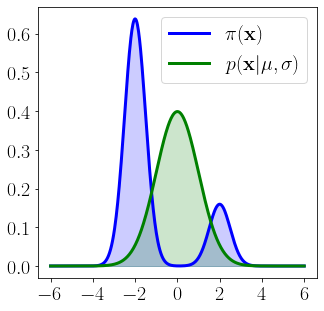

In [24]:
plot_distributions(X, mixture_gaussian, single_gaussian)

<img src="pics/kld_jsd.jpg" width=800 height=800 />

In [25]:
def KLD(X, log_prob1, log_prob2):
    # p and q return log pdf
    # X - some linspace
    return (log_prob1(X).exp() * (log_prob1(X) - log_prob2(X))).sum() * (X.max() - X.min()) / len(X)

In [26]:
def JSD(X, log_prob1, log_prob2):
    
    def log_prob_mean(x):
        prob_mean = (log_prob1(x).exp() + log_prob2(x).exp()) / 2
        return prob_mean.log()
    
    return (KLD(X, log_prob1, log_prob_mean) + KLD(X, log_prob2, log_prob_mean)) / 2

In [27]:
forward_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, real_log_prob, model_log_prob)
reverse_KL_loss_fn = lambda X, real_log_prob, model_log_prob: KLD(X, model_log_prob, real_log_prob)
JSD_loss_fn = lambda X, real_log_prob, model_log_prob: JSD(X, real_log_prob, model_log_prob)

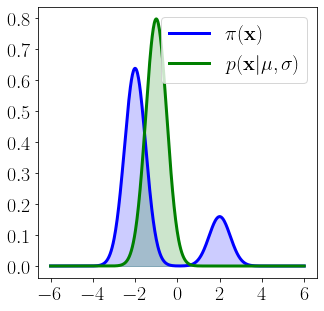

In [28]:
mu_start = -1
sigma_start = 0.5

# define trainable params
mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

plot_distributions(X, mixture_gaussian, single_gaussian)

In [29]:
def solve_task(optimizer, loss_fn, real_log_prob, model_log_prob, n_iters):
    for it in range(n_iters):
        optimizer.zero_grad()

        loss = loss_fn(X, real_log_prob, model_log_prob)
        loss.backward()
        optimizer.step()

        if it % 5 == 0: 
            plot_distributions(X, mixture_gaussian, single_gaussian, title=f'step: {it}, loss: {loss:.2f}')

In [ ]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, forward_KL_loss_fn, mixture_gaussian, single_gaussian, N_ITERS)

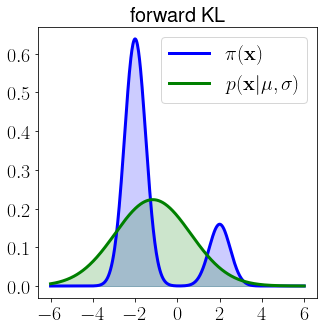

In [31]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='forward KL', 
    #savepath='forward_KL.png'
)

In [ ]:
N_ITERS = 50
LEARNING_RATE = 1e-1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, reverse_KL_loss_fn, mixture_gaussian, single_gaussian, N_ITERS)

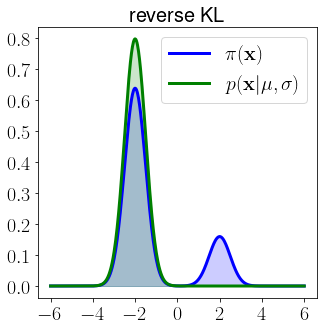

In [33]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='reverse KL', 
    #savepath='reverse_KL.png'
)

### Jensen Shannon optimization

In [ ]:
N_ITERS = 50
LEARNING_RATE = 0.1

mu_start = -1
sigma_start = 0.5

mu = torch.tensor(mu_start, requires_grad=True, dtype=torch.double)
sigma = torch.tensor(sigma_start, requires_grad=True, dtype=torch.double)
single_gaussian = get_gaussian_log_prob_fn(mu, sigma)

optimizer = torch.optim.SGD([mu, sigma], lr=LEARNING_RATE)

solve_task(optimizer, JSD_loss_fn, mixture_gaussian, single_gaussian, N_ITERS)

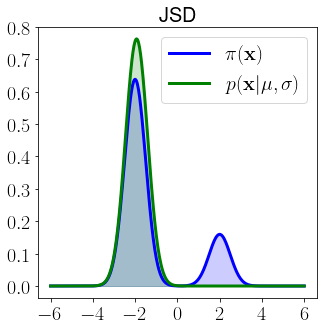

In [36]:
plot_distributions(
    X, 
    mixture_gaussian, 
    single_gaussian, 
    title='JSD', 
    #savepath='JSD.png'
)

# Vanilla GAN

<img src="pics/gan_objective.jpg" width=800 height=800 />

In [42]:
def get_simple_model(hiddens):
    assert len(hiddens) > 1

    modules = []
    for in_, out_ in zip(hiddens[:-2], hiddens[1:-1]):
        modules.extend([nn.Linear(in_, out_), nn.ReLU()])

    modules.append(nn.Linear(hiddens[-2], hiddens[-1]))

    return nn.Sequential(*modules)

In [46]:
# define shallow nn
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

In [47]:
####

In [48]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

In [49]:
def plot_gan_data(data_fn, noise_fn, data_pdf=None):
    noise = noise_fn(5000).numpy().flatten()
    target = data_fn(5000).numpy().flatten()
    
    plt.hist(noise, label='noise', alpha=0.5, density=True, color='b')
    plt.hist(target, label='target', alpha=0.5, density=True, color='g')
    if data_pdf is not None:
        x = np.linspace(-6,6,100)
        plt.plot(x, data_pdf(x), 'g', label='real distibution')

    plt.legend(loc='upper left')
    plt.show()

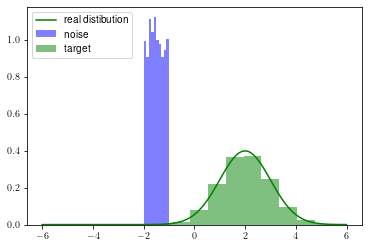

In [50]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [51]:
class VanillaGAN():
    def __init__(self, G, D, noise_fn, data_fn,
                 batch_size=32, device='cpu', lr_D=1e-3, lr_G=2e-4):
        """A GAN class for holding and training a generator and discriminator
        Args:
            G: a Ganerator network
            D: A Discriminator network
            noise_fn: function f(num: int) -> pytorch tensor, (latent vectors)
            data_fn: function f(num: int) -> pytorch tensor, (real samples)
            batch_size: training batch size
            device: cpu or CUDA
            lr_D: learning rate for the discriminator
            lr_G: learning rate for the generator
        """
        self.G = G
        self.G = self.G.to(device)
        self.D = D
        self.D = self.D.to(device)
        self.noise_fn = noise_fn
        self.data_fn = data_fn
        self.batch_size = batch_size
        self.device = device
        # !
        self.criterion = nn.BCELoss()
        self.optim_D = optim.Adam(D.parameters(),
                                  lr=lr_D, betas=(0.5, 0.999))
        self.optim_G = optim.Adam(G.parameters(),
                                  lr=lr_G, betas=(0.5, 0.999))
        # is needed in D train loop
        self.target_ones = torch.ones((batch_size, 1)).to(device)
        self.target_zeros = torch.zeros((batch_size, 1)).to(device)
    
    def generate_samples(self, latent_vec=None, num=None):
        """Sample from the generator.
        Args:
            latent_vec: A pytorch latent vector or None
            num: The number of samples to generate if latent_vec is None
        If latent_vec and num are None then us self.batch_size random latent
        vectors.
        ! We don't need grad for generated samples
        """
        num = self.batch_size if num is None else num
        latent_vec = self.noise_fn(num) if latent_vec is None else latent_vec
        # your code here
        with torch.no_grad():
            samples = self.G(latent_vec)
        return samples

    def train_step_G(self):
        """Train the generator one step and return the loss."""
        self.G.zero_grad()
        latent_vec = self.noise_fn(self.batch_size)
        # your code here
        # use self.target_ones
        generated = self.G(latent_vec)
        classifications = self.D(generated)
        loss = self.criterion(classifications, self.target_ones)
        loss.backward()
        self.optim_G.step()
        return loss.item()

    def train_step_D(self):
        """Train the discriminator one step and return the losses."""
        self.D.zero_grad()

        # real samples
        real_samples = self.data_fn(self.batch_size)
        # calc real loss
        # you code here
        pred_real = self.D(real_samples)
        loss_real = self.criterion(pred_real, self.target_ones)

        # generated samples
        latent_vec = self.noise_fn(self.batch_size)
        # calc fake loss
        # you shouldn't optimize G here
        # you code here
        
        with torch.no_grad():
            fake_samples = self.G(latent_vec)
        pred_fake = self.D(fake_samples)
        loss_fake = self.criterion(pred_fake, self.target_zeros)

        # combine
        loss = (loss_real + loss_fake) / 2
        loss.backward()
        self.optim_D.step()
        
        return loss_real.item(), loss_fake.item()

    def train_step(self):
        """Train both networks and return the losses."""
        loss_D = self.train_step_D()
        loss_G = self.train_step_G()
        return loss_G, loss_D

In [52]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

In [53]:
def visualize_GAN(gan, data_pdf=None):
    size = 500
    x = np.linspace(-6,6,100)
    bins = np.linspace(-6,6,60)
    real_data = gan.data_fn(size)
    noise = gan.noise_fn(size)
    sampled_data = gan.generate_samples(noise)
    
    plt.hist(noise.numpy(), label='noise', alpha=0.5, density=True, color='b', bins=bins)
    plt.hist(real_data.numpy(), label='real data', alpha=0.5, density=True, color='g', bins=bins)
    plt.hist(sampled_data.numpy(), label='G samples', alpha=0.5, density=True, color='r', bins=bins)
    
    if data_pdf is not None:
        plt.plot(x, data_pdf(x), 'g', label='real distibution')
    with torch.no_grad():
        plt.plot(x, gan.D(torch.from_numpy(x).float().unsqueeze(-1)).numpy(), 'b', label='D distibution')
    
    plt.legend(loc='upper left')
    plt.show()

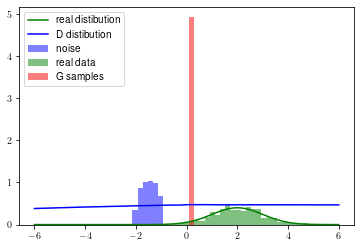

In [54]:
visualize_GAN(gan, data_pdf=data_pdf)

In [55]:
mu = 2
noise_fn = lambda x: torch.rand((x, 1), device='cpu')-2
data_fn = lambda x: mu+torch.randn((x, 1), device='cpu')
data_pdf = lambda X: norm.pdf(X-mu)

gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')

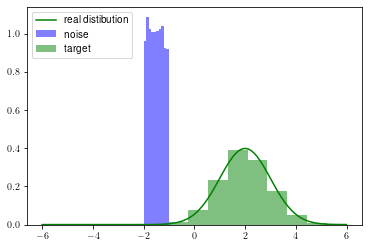

In [56]:
plot_gan_data(data_fn, noise_fn, data_pdf)

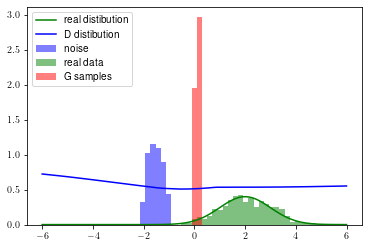

In [57]:
visualize_GAN(gan, data_pdf=data_pdf)

In [58]:
epochs = 50
batches = 100

In [60]:
step_size = 1
loss_g, loss_d_real, loss_d_fake = [], [], []
start = time()
for epoch in range(epochs):
    break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        #lg_, (ldr_, ldf_) = gan.train_step()
        ldr_, ldf_ = gan.train_step_D()
        if i%step_size == 0:
            print(i)
            print('D train step')
            visualize_GAN(gan)
        lg_ = gan.train_step_G()
        if i%step_size == 0:
            print('G train step')
            visualize_GAN(gan)
        
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)

In [61]:
######

In [62]:
mu1 = 3
mu2 = -3
k = 0.7

noise_fn = lambda x: torch.rand((x, 1), device='cpu') - 0.5

def data_fn(x):
    a = mu1 + torch.randn((x, 1), device='cpu')
    b = mu2 + torch.randn((x, 1), device='cpu')
    mask = np.random.rand(x) < k
    mask = mask[:, None]
    samples = (a * mask + b * (1 - mask))
    
    return samples.float()

data_pdf = lambda X: k*norm.pdf(X-mu1)+(1-k)*norm.pdf(X-mu2)

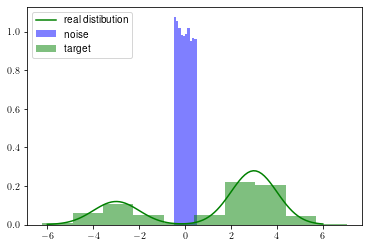

In [63]:
plot_gan_data(data_fn, noise_fn, data_pdf)

In [64]:
gen_hiddens = [1,64,64,1]
dis_hiddens = [1,64,64,1]
G = get_simple_model(gen_hiddens)
D = nn.Sequential(*get_simple_model(dis_hiddens), nn.Sigmoid())

gan = VanillaGAN(G, D, noise_fn, data_fn, device='cpu')
loss_g, loss_d_real, loss_d_fake = [], [], []

In [65]:
epochs = 20
batches = 100

In [68]:
start = time()
for epoch in range(epochs):
    break
    loss_g_running, loss_d_real_running, loss_d_fake_running = 0, 0, 0
    for i,batch in enumerate(range(batches)):
        lg_, (ldr_, ldf_) = gan.train_step()
        loss_g_running += lg_
        loss_d_real_running += ldr_
        loss_d_fake_running += ldf_
    loss_g.append(loss_g_running / batches)
    loss_d_real.append(loss_d_real_running / batches)
    loss_d_fake.append(loss_d_fake_running / batches)
    print(f"Epoch {epoch+1}/{epochs} ({int(time() - start)}s):"
          f" G={loss_g[-1]:.3f},"
          f" Dr={loss_d_real[-1]:.3f},"
          f" Df={loss_d_fake[-1]:.3f}")
    visualize_GAN(gan, data_pdf=data_pdf)